## Random Number Generator
The goal of this notebook is to have a working random number generator that outputs much like random.randint(), but using a quantum computer. I am not really aiming for an unbounded function but something that could generate theoretical true-random integers relatively quickly.

In [13]:
import os
import numpy as np
import sys
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (SamplerV2 as Sampler)
from qiskit.primitives import (BackendSamplerV2)

In [ ]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [ ]:
# Connect to least busy backend.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

# Single Integer Generation
Using the same method as a single qubit 'coinflip', I think we should be able to implement by just coinflipping n-bits, and converting the bitstring into something recognisable. I am not sure if/how entanglement will get involved, as I don't know much about it, but I will try implement this for now.

In [4]:
def generate_circuit(n):
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)
    qc = QuantumCircuit(qr, cr)
    qc.h(qr) # hadamard gate each qubit
    qc.measure_all()
    return qr, cr, qc

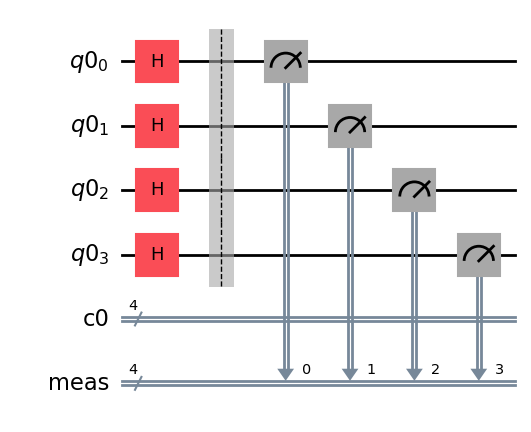

In [5]:
# Generate 4-qubit circuit for random numbers 0 to 15.
qr, cr, qc = generate_circuit(4)
qc.draw('mpl')

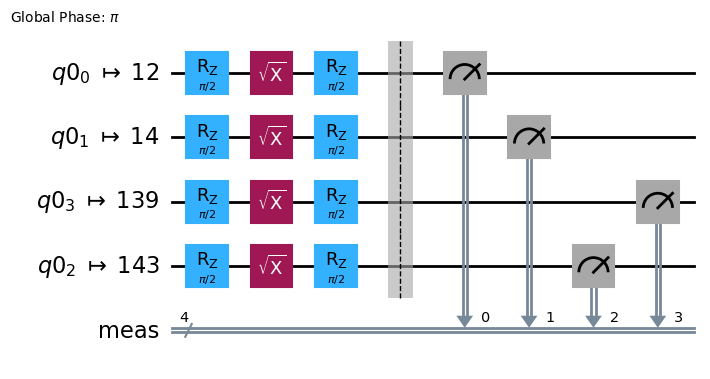

In [6]:
# Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

I find it interesting that the ordering for measuring changes. I (maybe wrongly) assume this has something to do with Quantum Error Correction inbuilt into the optimiser, but I will have to look into it. The global phase is $\pi$ but I don't think that will influence sampled results measured in the z-basis.

In [7]:
# Run sample on quantum simulator of backend
backend_sim = AerSimulator.from_backend(backend)
sampler_sim = BackendSamplerV2(backend=backend_sim)
job = sampler_sim.run([[qc_isa]], shots = 1)
res = job.result()

In [8]:
bitstring, _ = res[0].data.meas.get_counts().popitem()
print('Random number: ', bitstring, ' = ', int(bitstring, 2))

Random number:  0110  =  6


# Multiple Random Number Generation
Now I can do that 10000 times, and might as well do it on real hardware.

In [9]:
## Run sample 10000 times on hardware
# sampler = Sampler(mode=backend)
# pubs = [qc_isa]
# job = sampler.run(pubs, shots=10000)
# res = job.result()

service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45vru9me48c73d7m0b0')
res = job.result()

qiskit_runtime_service._discover_account:WARNING:2025-11-13 13:23:30,391: Loading account with the given token. A saved account will not be used.


In [10]:
bitstrings = res[0].data.meas.get_counts()
integers = {int(bitstring, 2): count for bitstring, count in bitstrings.items()}
print(integers)

{9: 682, 12: 631, 4: 600, 2: 661, 7: 588, 6: 583, 3: 640, 0: 616, 15: 588, 11: 683, 13: 617, 1: 613, 14: 609, 8: 621, 10: 672, 5: 596}


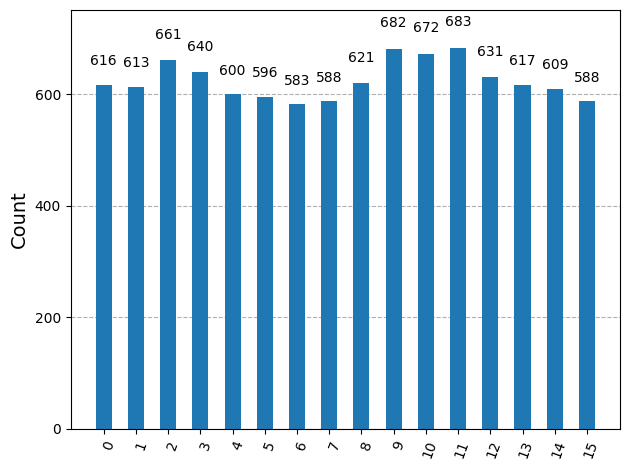

In [11]:
plot_histogram(integers)

If I am honest, I expected more variation across the sample, but this has done an okay job. My basic hypothesis is that only four qubits are being used so interference is less of an issue. There is a peak at 2-3 and 9-11, but it is hard to know if certain integers are being converged to more frequently without further tests on the distribution.

For now, I could potentially try and estimate the EV of the Z-gate on each qubit with the Estimator primitive, or just see how many times each of the four qubits measured $|0\rangle$ and $|1\rangle$.

In [14]:
# initialize counter for number of times each qubit is in the 1 position
ones = [0, 0, 0, 0]

for bitstring, count in bitstrings.items():
    for i, bit in enumerate(bitstring):
        if bit == '1': # count number of times qubit is measured in state 1
            ones[i] += count

zeros = np.array([10000,10000,10000,10000])-ones # corresponding number of 0 states.
expected_values = 0.5*(zeros-ones)/10000 # estimate expected value

print(expected_values)

[-0.0103  0.0188 -0.0024 -0.0007]


'Seems small' - a scientific conclusion. At least in this very basic analysis there is no clear weighting, so I can be confident enough, it is random.

## Comparison to Python's random.randint()

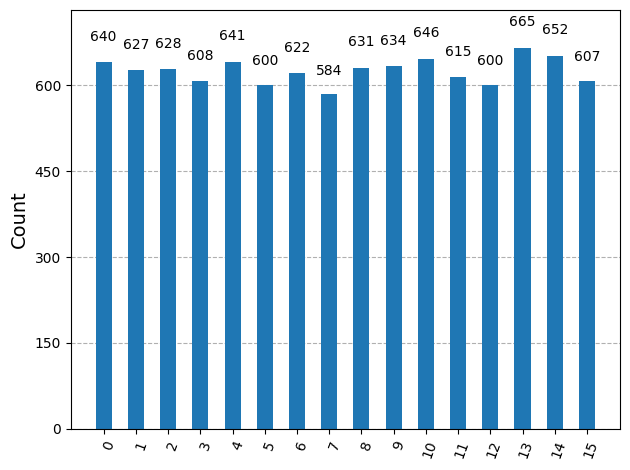

In [15]:
import random

max = 15
counts = [0 for i in range(max+1)] # store counts of each number 0-15.
for i in range(10000): # run random function 10000 times.
    counts[random.randint(0,max)] += 1

# plot histogram of results.
counts_dict = {i: count for i, count in enumerate(counts)}
plot_histogram(counts_dict)

hmmmmm. This actually looks very similar, if not better than the quantum random simulation.

# Big Integers
Most of the IBM quantum computers available to us have upwards of 100 qubits. IBM_Fez has 156 available qubits, which would allow me to generate in the range of $2^{156}-1$, an order of $10^{46}$, in one pass. If I ran the circuit twice I could stitch two bitstrings together to make a number in the order of $2^{312}-1$. I could keep doing this many times. I am not sure what memory issues this may run into but the inbuilt 'int()' function is unbounded.


In [ ]:
# Create circuit
n = backend.num_qubits
qr, cr, qc = generate_circuit(n)

# Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

In [ ]:
# # Generate very large number on hardware
# sampler = Sampler(mode=backend)
# pubs = [qc_isa]
# job = sampler.run(pubs, shots=1)
# res = job.result()

service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d460e1d63mfc73a7hde0')
res = job.result()

In [21]:
bitstring = res[0].data.meas.get_counts().popitem()[0] # get bitstring from output
print('Random number: ', bitstring, ' = ', int(bitstring, 2))

Random number:  011100000100101100001110010110011011010110100100001010101001011111111110111110111111010110010001101101110001101110111011010001000000011100010011000010110110  =  40067548270046011992633922778287616586222219446


And using random.randint():

In [22]:
very_large_random_number = random.randint(0,2**n - 1)
print(very_large_random_number)

73835616562995774674009212978274292330851958062


My CPU handled this much quicker, and without the need for fancy quantum technologies. However, these types of functions rely on seeding some set of instructions to give an even distribution of generated numbers. This is completely deterministic. If I knew the seed, I could replicate the 'random' outcome. For example, some random number generators use unix time to generate a seed, which they pass into their distributing function. This is actually a relatively small search space if you were to look into replicating the outcome. This comes with obvious issues for security processes that rely on very large random numbers.

# Generating numbers in a range $[min, max)$.
For this I am going to be using the fast dice roller algorithm as described by J. Lumbroso (2013) in https://arxiv.org/abs/1304.1916. It lets us randomly generate a number between min and max, provided we can easily uniformly generate random bits. It should be easy to generate a list of n random bits using our quantum circuit, and then just sample one by one from that list in the algorithm.

Instead of min and max, suppose we want to generate in the range of $[0, x)$, we have that:
  - $x - 1 \leq 2^{n}-1 \iff log_{2}(x) \leq n \iff n = \lceil log_{2}(x) \rceil $

This is the best case scenario. In reality most algorithms will need more bits available than this because they rely on rejecting if we have picked a number too big. Worst case, on average, we have a couple more steps in the algorithm, and number of bits. This shouldn't really be a problem, as it's still $O(\log x)$, and I am not particularly concerned with speed.

In [ ]:
def fast_dice_roller(min_inclusive, max_exclusive, bitlist):
    '''
    Generate random integer in range given a stream of unbiased bits
    :param min_inclusive: minimal range value
    :param max_exclusive: maximal range value, exclusive
    :param bitlist: stream of randomly generated bits
    :return: random bitstring b
    '''
    max_inclusive = max_exclusive - min_inclusive - 1
    x = 1
    y = 0
    while True:
       x = x * 2
       random_bit = bitlist.pop()
       y = y * 2 + random_bit
       if x > max_inclusive:
           if y <= max_exclusive: return y + min_inclusive
           ## Reject
           x = x - max_inclusive - 1
           y = y - max_inclusive - 1

In [24]:
def generate_bitstring(n):
    '''
    Generate bitstring of length n using IBM quantum service.
    :param n: number of bits (or qubits)
    :return:
    '''
    # Create circuit
    qr, cr, qc = generate_circuit(n)

    # Transpile
    target = backend.target
    if n > backend.num_qubits: raise('Not enough qubits to generate that large a number')
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    qc_isa = pm.run(qc)

    # Run sample on hardware
    sampler = Sampler(mode=backend)
    pubs = [qc_isa]
    job = sampler.run(pubs, shots=1)
    res = job.result()

    # return bitstring
    bitstring = res[0].data.meas.get_counts().popitem()[0]
    return bitstring

In [25]:
import math
def quantum_random_int(min, max) -> int:
    '''
    Generate random number in range
    :param min: minimal range value
    :param max: maximal range value, not inclusive
    :return:
    '''
    n = math.ceil(np.log2(max-min)+2) # estimate how many qubits we will need
    bitstring = generate_bitstring(n) # run quantum circuit to get list of bits
    bitlist = [int(bit) for bit in bitstring] # convert bitstring to list of integers
    random_number = fast_dice_roller(min, max, bitlist) # run algorithm
    return random_number

In [115]:
# generate number between 1 and 99999
my_random_number = quantum_random_int(1, 100000)

In [116]:
print(my_random_number)

28182


A basic implementation - not very robust and only works for up to 156 qubits, but it is a good proof of concept. **`quantum_rng.py`** is a formal version of this - I added some more functionality, robustness and cleaned it up a bit.

# Weighted Random Numbers
In my coinflip notebook I was able to weight the qubit so that I measured 0 75% of the time. I wonder if I could use the same idea so that I can generate certain numbers more than others. For example, it would be easy to generate more even numbers than odd numbers by weighting the first bit in our bitstring that accounts for 0 or 1.

In [ ]:
# generate circuit
n = 4
qr = QuantumRegister(n)
# cr = ClassicalRegister(n)
qc = QuantumCircuit(qr)
qc.h(qr)
qc.p(np.pi/3, qr[0])
qc.h(qr[0])
qc.measure_all()
qc.draw('mpl')

In [98]:
# Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

In [103]:
## Run sample 1000 times on hardware
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=10000)
res = job.result()

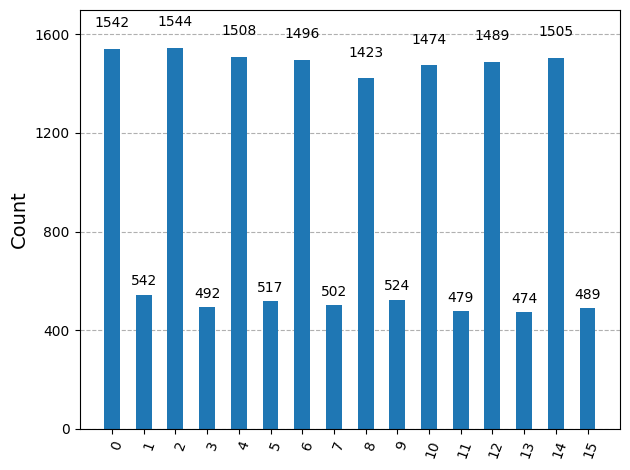

In [102]:
bitstrings = res[0].data.meas.get_counts()
integers = {int(bitstring, 2): count for bitstring, count in bitstrings.items()}
plot_histogram(integers)

This would make a great gimmicky roulette table.